In [1]:
import re
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdChemReactions, rdFMCS, inchi, rdDepictor
from rdchiral.main import rdchiralRun, rdchiralRunText, rdchiralReaction, rdchiralReactants

from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from IPython.display import SVG
from copy import deepcopy

import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

### Step 1: Extract all alcohol dehydrogenase reactions from EnzymeMap's MetaCyc V27 dataset.

In [2]:
JN1224MIN_rules_df = pd.read_csv('./JN1224MIN_rules.tsv', delimiter = '\t')
M27_df = pd.read_csv('./Esther_Heid_MetaCyc_processed.csv')

In [3]:
JN_labelled_rules = []
for rule in list(M27_df['rule']):
    try:
        JN_labelled_rules.append(list(JN1224MIN_rules_df[JN1224MIN_rules_df['SMARTS']==rule]['Name'])[0])
    except IndexError:
        JN_labelled_rules.append(None)
        
M27_df['JN_labelled_rule'] = JN_labelled_rules
AdH_rxns_df = M27_df[ (M27_df['JN_labelled_rule']=='rule0002') & (M27_df['source']=='direct')]

In [4]:
AdH_rxns_df = AdH_rxns_df.drop_duplicates(subset=['mapped', 'unmapped'], keep='first')

### Step 2: Define a function to extract the atom index of the carbon atom within the substrate that specifically undergoes dehydrogenation.

In [5]:
# Helper function to extract atom-mapped bonds
def get_mapped_bonds(mol):
    bonds = set()
    for bond in mol.GetBonds():
        begin_atom = bond.GetBeginAtom()
        end_atom = bond.GetEndAtom()

        # Only consider atom-mapped atoms
        if begin_atom.GetAtomMapNum() > 0 and end_atom.GetAtomMapNum() > 0:
            bond_tuple = (begin_atom.GetAtomMapNum(), end_atom.GetAtomMapNum(), bond.GetBondType())
            bonds.add(bond_tuple)
    return bonds

In [6]:
def get_changed_atoms(reaction_smarts):
    # Create an RDKit reaction object from SMARTS
    reaction = Chem.AllChem.ReactionFromSmarts(reaction_smarts)
    
    reactants = reaction.GetReactants()
    products = reaction.GetProducts()
    
    reactant_bonds = set()
    product_bonds = set()
    
    # Collect bonds from all reactants
    for reactant in reactants:
        reactant_bonds |= get_mapped_bonds(reactant)
    
    # Collect bonds from all products
    for product in products:
        product_bonds |= get_mapped_bonds(product)
    
    # Identify broken and formed bonds
    broken_bonds = reactant_bonds - product_bonds  # Bonds present in reactants but not in products
    formed_bonds = product_bonds - reactant_bonds  # Bonds present in products but not in reactants
    
    # Collect atom map numbers involved in broken or formed bonds
    changed_atoms = set()
    for bond in broken_bonds.union(formed_bonds):
        changed_atoms.add(bond[0])  # Atom map number of the first atom
        changed_atoms.add(bond[1])  # Atom map number of the second atom
    
    return changed_atoms, broken_bonds, formed_bonds

In [7]:
def check_if_cofactor(atom_mapped_smarts: str) -> bool:
    """
    Takes an atom-mapped smarts string corresponding to a species then checks if this is a cofactor
    Returns True if species is a cofactor and False if it is a substrate or product
    """
    
    nad_plus_smiles = '[NH2]C(=O)c1[cH][cH][cH][n+]([C@@H]2O[C@H]([CH2]OP(=O)([OH])OP(=O)([OH])O[CH2][C@H]3O[C@@H](n4[cH]nc5c([NH2])n[cH]nc54)[C@H]([OH])[C@@H]3[OH])[C@@H]([OH])[C@H]2[OH])[cH]1'
    nadp_plus_smiles = '[NH2]C(=O)c1[cH][cH][cH][n+]([C@@H]2O[C@H]([CH2]OP(=O)([OH])OP(=O)([OH])O[CH2][C@H]3O[C@@H](n4[cH]nc5c([NH2])n[cH]nc54)[C@H](OP(=O)([OH])[OH])[C@@H]3[OH])[C@@H]([OH])[C@H]2[OH])[cH]1'
    
    nadh_smiles = '[NH2]C(=O)C1=[CH]N([C@@H]2O[C@H]([CH2]OP(=O)([OH])OP(=O)([OH])O[CH2][C@H]3O[C@@H](n4[cH]nc5c([NH2])n[cH]nc54)[C@H]([OH])[C@@H]3[OH])[C@@H]([OH])[C@H]2[OH])[CH]=[CH][CH2]1'
    nadph_smiles = '[NH2]C(=O)C1=[CH]N([C@@H]2O[C@H]([CH2]OP(=O)([OH])OP(=O)([OH])O[CH2][C@H]3O[C@@H](n4[cH]nc5c([NH2])n[cH]nc54)[C@H](OP(=O)([OH])[OH])[C@@H]3[OH])[C@@H]([OH])[C@H]2[OH])[CH]=[CH][CH2]1'
    
    cofactors_list = [nad_plus_smiles, nadp_plus_smiles, nadh_smiles, nadph_smiles]
    
    mol = Chem.MolFromSmarts(atom_mapped_smarts)
    
    # remove atom mapping numbers
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
    
    # convert the molecule back to a SMILES string without atom mapping numbers
    smiles_string = Chem.MolToSmiles(mol, isomericSmiles = True, canonical = True)
    
    if smiles_string in cofactors_list:
        return True
                                     
    else:
        return False

In [8]:
def check_if_changed_atom_in_substrate(changed_atom_indices: set, reaction_smarts: str):
    
    # initialize an empty list to store the atom index where a reaction occurs on a substrate
    reactive_site_index = []
    
    reactants_list = reaction_smarts.split('>>')[0].split('.')
    
    # for each atom-mapped reactant
    for reactant_smarts in reactants_list:
        
        # check first each atom index corresponding to a changed atom undergoes a change is in this reactant
        for atom_idx in list(changed_atom_indices):
            if f':{atom_idx}' in reactant_smarts:
                
                # if reactant species holding this atom index is a cofactor, dont store atom index as reactive site
                if check_if_cofactor(reactant_smarts):
                    pass
                
                # if reactant species holding this atom index is indeed a substrate, save it as a reactive site
                else:
                    pattern = re.compile(r'\[[Cc][^\]]*:' + str(atom_idx) + r'\]')
                    match = pattern.findall(reactant_smarts)
                    if match:
                        reactive_site_index.append(atom_idx)

    return reactive_site_index

In [9]:
rxn_idx = 0

In [10]:
changed_atoms, broken_bonds, formed_bonds = get_changed_atoms(list(AdH_rxns_df['mapped'])[rxn_idx])

In [11]:
reaction_smarts = list(AdH_rxns_df['mapped'])[rxn_idx]

In [12]:
check_if_changed_atom_in_substrate(changed_atoms, reaction_smarts)

[2]

In [13]:
list(AdH_rxns_df['mapped'])[rxn_idx]

'[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]1[cH:8][cH:9][cH:10][n+:11]([C@@H:12]2[O:13][C@H:14]([CH2:15][O:16][P:17](=[O:18])([OH:19])[O:20][P:21](=[O:22])([OH:23])[O:24][CH2:25][C@H:26]3[O:27][C@@H:28]([n:29]4[cH:30][n:31][c:32]5[c:33]([NH2:34])[n:35][cH:36][n:37][c:38]45)[C@H:39]([OH:40])[C@@H:41]3[OH:42])[C@@H:43]([OH:44])[C@H:45]2[OH:46])[cH:47]1>>[CH3:1][CH:2]=[O:3].[H+].[NH2:4][C:5](=[O:6])[C:7]1=[CH:47][N:11]([C@@H:12]2[O:13][C@H:14]([CH2:15][O:16][P:17](=[O:18])([OH:19])[O:20][P:21](=[O:22])([OH:23])[O:24][CH2:25][C@H:26]3[O:27][C@@H:28]([n:29]4[cH:30][n:31][c:32]5[c:33]([NH2:34])[n:35][cH:36][n:37][c:38]45)[C@H:39]([OH:40])[C@@H:41]3[OH:42])[C@@H:43]([OH:44])[C@H:45]2[OH:46])[CH:10]=[CH:9][CH2:8]1'

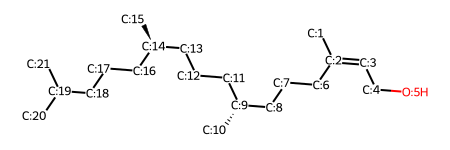

In [14]:
Chem.MolFromSmiles('[CH3:1]/[C:2](=[CH:3]/[CH2:4][OH:5])[CH2:6][CH2:7][CH2:8][C@H:9]([CH3:10])[CH2:11][CH2:12][CH2:13][C@H:14]([CH3:15])[CH2:16][CH2:17][CH2:18][CH:19]([CH3:20])[CH3:21]')

### Step 3: Deploy this function to get the index of the carbon atom that will undergo dehydrogenation for every alcohol dehydrogenation reaction in MetaCyc V27.

In [15]:
all_rxn_site_coordinates = []
idx_to_keep = []

for rxn_idx in range(0,AdH_rxns_df.shape[0]):
    changed_atoms, broken_bonds, formed_bonds = get_changed_atoms(list(AdH_rxns_df['mapped'])[rxn_idx])
    reaction_smarts = list(AdH_rxns_df['mapped'])[rxn_idx]
    reactive_site = check_if_changed_atom_in_substrate(changed_atoms, reaction_smarts)
    
    if len(reactive_site) == 1:
        all_rxn_site_coordinates.append(reactive_site[0])
        idx_to_keep.append(rxn_idx)

In [16]:
print(f'The reactive carbon atoms undergoing dehydrogenation were successfully obtained for {len(all_rxn_site_coordinates)} reactions')


The reactive carbon atoms undergoing dehydrogenation were successfully obtained for 380 reactions


In [17]:
AdH_rxns_df = AdH_rxns_df.iloc[idx_to_keep, :]

In [18]:
AdH_rxns_df.loc[:,'Reaction_site_idx'] = all_rxn_site_coordinates

In [19]:
AdH_rxns_df.head(5)

,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx
0,903,[CH3:1][CH2:2][OH:3].[NH2:4][C:5](=[O:6])[c:7]...,CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP...,ALCOHOL-DEHYDROG-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,2
4,2324,[CH3:1][O:2][c:3]1[cH:4][c:5]([C@@H:6]([OH:7])...,COc1cc([C@@H](O)CO)ccc1O.NC(=O)c1ccc[n+]([C@@H...,RXN-10915,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,8
7,5135,[CH3:1][C@@H:2]([OH:3])[CH2:4][CH2:5][OH:6].[N...,C[C@@H](O)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](CO...,RXN-21862,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,5
9,5743,[CH3:1][CH:2]([CH3:3])[CH2:4][OH:5].[NH2:6][C:...,CC(C)CO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(...,RXN-7657,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,4
11,5751,[CH3:1][CH:2]([CH3:3])[CH2:4][CH2:5][OH:6].[NH...,CC(C)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,RXN-7693,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,5


### Step 4: With the reactive carbon undergoing dehydrogenation obtained for each alcohol dehydrogenation reaction, extract the chemical environments around such carbons at radii of 1, 2, 3, and 4 bonds around this carbon.

In [20]:
def get_env_around_reaction_site_single_reactant(atom_mapped_substrate_smarts: str, 
                                                 radius: int, 
                                                 starting_atom_idx: int):
    
    """
    Extract the chemical environment around the specified reactive carbon atom at a specified bond radius.
    The resulting chemical environment is returned as a SMARTS string
    
    Example usage:
    
    atom_mapped_substrate_smarts = '[CH3:1][O:2][c:3]1[cH:4][c:5]([C@@H:6]([OH:7])[CH:8][O:9])[cH:10][cH:11][c:12]1[OH:13]'
    starting_atom_idx = 8
    
    radius = 1
    get_env_around_reaction_site_single_reactant(atom_mapped_substrate_smarts, radius, starting_atom_idx)
    >> [C&H1:8][O:9]
    
    radius = 2
    get_env_around_reaction_site_single_reactant(atom_mapped_substrate_smarts, radius, starting_atom_idx)
    >> [C&H1:8]([C@@&H1:6])[O:9]
    
    radius = 3
    get_env_around_reaction_site_single_reactant(atom_mapped_substrate_smarts, radius, starting_atom_idx)
    >> [c:5][C@@&H1:6]([O&H1:7])[C&H1:8][O:9]
    
    radius = 4
    get_env_around_reaction_site_single_reactant(atom_mapped_substrate_smarts, radius, starting_atom_idx)
    >> [c&H1:4][c:5]([C@@&H1:6]([O&H1:7])[C&H1:8][O:9])[c&H1:10]
    """
    
    substrate_mol = Chem.MolFromSmarts(atom_mapped_substrate_smarts)
    
    # get initial reaction environment
    reaction_environment = Chem.FindAtomEnvironmentOfRadiusN(mol = substrate_mol, 
                                                             radius = radius, 
                                                             rootedAtAtom = starting_atom_idx)
    
    # from this initial reaction environment around the reactive site, extract bond indices
    bond_indices = list(reaction_environment)
    
    # with these bond_indices, collect the atom_indices of atoms linked by these bonds
    atom_indices = set()
    
    for bond_idx in bond_indices:
        bond = substrate_mol.GetBondWithIdx(bond_idx)
        atom_indices.add(bond.GetBeginAtomIdx())
        atom_indices.add(bond.GetEndAtomIdx())
        
    final_env_smarts = Chem.MolFragmentToSmarts(substrate_mol, atomsToUse=list(atom_indices))
    
    return final_env_smarts

In [21]:
def fix_rxn_site_number(reactant_smarts: str, 
                        reactive_carbon_idx_from_atom_map: str):
    """
    The index of the reactive carbon atom obtained previously is that obtained from atom mapping.
    This index, however, does not necessarily correspond to that internally used by RDKit.
    Consequently, we run a correction step wherein we iterate over 
    """
    
    reactant_mol = Chem.MolFromSmarts(reactant_smarts)
    
    for atom in reactant_mol.GetAtoms():
        if atom.GetAtomMapNum() == reactive_carbon_idx_from_atom_map:
            corrected_reactive_atom_idx = atom.GetIdx()
            
    return corrected_reactive_atom_idx

In [285]:
### Here, we extract chemical environments with some predetermined radius
radius = 4

# initialize a list to store all substructure environments in terms of their SMARTS
all_env_smarts = []

# initialize an empty list to store the indexes of all rows to keep
idx_to_keep = []

for rxn_idx in range(0, AdH_rxns_df.shape[0]):
    
    rxn_smarts = AdH_rxns_df.iloc[rxn_idx,:]['mapped']
    reactive_carbon_idx = AdH_rxns_df.iloc[rxn_idx,:]['Reaction_site_idx']
    
    reactant_smarts_list, product_smarts_list = rxn_smarts.split('>>')
    
    for reactant_smarts in reactant_smarts_list.split('.'):
        
        if check_if_cofactor(reactant_smarts) == False:
            
            corrected_atom_idx = fix_rxn_site_number(reactant_smarts = reactant_smarts, 
                                                      reactive_carbon_idx_from_atom_map = reactive_carbon_idx)
            
            try:
                
                env_smarts = get_env_around_reaction_site_single_reactant(reactant_smarts, 
                                                                          radius, 
                                                                          corrected_atom_idx)
                
                all_env_smarts.append(env_smarts)
                idx_to_keep.append(rxn_idx)
            
            except:
                pass

In [286]:
AdH_rxns_df_w_substructs = AdH_rxns_df.iloc[idx_to_keep,:]

In [287]:
AdH_rxns_df_w_substructs['substructure_environments'] = all_env_smarts

In [288]:
AdH_rxns_df_w_substructs.iloc[3,:]['substructure_environments']

'[O&H1:49][C&H2:50][C@@&H1:51]([O&H1:52])[C@&H1:53]([O&H1:54])[C@@&H1:55]([O&H1:56])[C&H2:57][O&H1:58]'

In [289]:
AdH_rxns_df_w_substructs.iloc[3,:]['unmapped']

'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.OC[C@@H](O)[C@H](O)[C@@H](O)CO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=C(CO)[C@H](O)[C@@H](O)CO.[H+]'

In [290]:
list(AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']=='NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.OCCc1ccccc1>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCc1ccccc1.[H+]']['substructure_environments'])[0]


'[O&H1:45][C&H2:46][C&H2:47][c:48]([c&H1:49][c&H1:50])[c&H1:53][c&H1:52]'

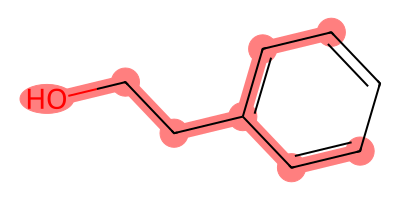

In [292]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('OCCc1ccccc1')
substructure = Chem.MolFromSmarts('[O&H1:45][C&H2:46][C&H2:47][c:48]([c&H1:49][c&H1:50])[c&H1:53][c&H1:52]')
SVG(increase_resolution(mol, substructure))

In [168]:
# Function to reset atom map numbers sequentially
def reset_atom_map_numbers(smarts):
    mol = Chem.MolFromSmarts(smarts)
    
    # Sequentially assign new atom map numbers (starting from 1)
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(i + 1)
    
    # Convert back to SMARTS with the new atom map numbers
    return Chem.MolToSmarts(mol)

In [169]:
rule_smarts_reset = []
strip_stereochemistry = False

for r in list(AdH_rxns_df_w_substructs['substructure_environments']):
    
    if strip_stereochemistry:
        r = r.replace('@', '') # remove stereochemistry if specified
        rule_smarts_reset.append(reset_atom_map_numbers(r))
    
    else:
        rule_smarts_reset.append(reset_atom_map_numbers(r))

In [170]:
# Dictionary to store groupings based on exact SMARTS string
grouped_smarts = {}

# Group the SMARTS strings by their exact content
for idx, smarts in enumerate(rule_smarts_reset):
    if smarts not in grouped_smarts:
        grouped_smarts[smarts] = []
    grouped_smarts[smarts].append(idx)

# Output the groupings
group_memberships = np.zeros(len(rule_smarts_reset))
group_number = 0
for group, indices in grouped_smarts.items():
    
    group_number += 1
    print(f"Group (SMARTS): {group}")
    print(f"Row indices: {indices}")
    print(f"Group number: {group_number}")
    print()
    
    for idx in indices:
        group_memberships[idx] = group_number

Group (SMARTS): [c&H1:1][c:2]([C@@&H1:3]([O&H1:4])[C&H2:5][O&H1:6])[c&H1:7]
Row indices: [0]
Group number: 1

Group (SMARTS): [C&H3:1][C@@&H1:2]([O&H1:3])[C&H2:4][C&H2:5][O&H1:6]
Row indices: [1]
Group number: 2

Group (SMARTS): [C&H3:1][C&H1:2]([C&H3:3])[C&H2:4][C&H2:5][O&H1:6]
Row indices: [2]
Group number: 3

Group (SMARTS): [O&H1:1][C&H2:2][C&H2:3][c:4]([c&H1:5])[c&H1:6]
Row indices: [3]
Group number: 4

Group (SMARTS): [C&H3:1]/[C:2](=[C&H1:3]/[C&H2:4][O&H1:5])[C&H2:6]
Row indices: [4]
Group number: 5

Group (SMARTS): [O&H1:1][C&H2:2][C@@&H1:3]([O&H1:4])[C@&H1:5]([O&H1:6])[C@@&H1:7]([O&H1:8])[C&H2:9]
Row indices: [5, 76, 343]
Group number: 6

Group (SMARTS): [C&H3:1][C@@&H1:2]([O&H1:3])[C@&H1:4]([N&H3&+:5])[C:6](=[O:7])[O&-:8]
Row indices: [6]
Group number: 7

Group (SMARTS): [C:1][C@@&H1:2]1[C&H2:3][C@&H1:4]([O&H1:5])[C&H2:6][N&H2&+:7]1
Row indices: [7]
Group number: 8

Group (SMARTS): [C&H3:1][C:2](=[C&H1:3][C&H2:4][O&H1:5])-[C&H1:6]
Row indices: [8, 202]
Group number: 9

Group 

In [171]:
AdH_rxns_df_w_substructs['Group'] = group_memberships

In [172]:
for x in list(AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['Group']==98]['unmapped']):
    print(x)
    print('')

NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.OC[C@H](O)C(O)[C@@H](O)CO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=C[C@H](O)C(O)[C@@H](O)CO.[H+]



In [173]:
list(AdH_rxns_df_w_substructs['unmapped'])[2]

'CC(C)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CC(C)CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'

In [176]:
rxn_str = 'C[C@@H](O)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>C[C@@H](O)CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'
list(AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]['substructure_environments'])[0]


'[C&H3:1][C@@&H1:2]([O&H1:3])[C&H2:4][C&H2:5][O&H1:6]'

In [107]:
list(AdH_rxns_df_w_substructs['unmapped'])[4]

'CC(C)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CC(C)CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'

In [108]:
rxn_str = 'CC(C)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CC(C)CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
11,5751,[CH3:1][CH:2]([CH3:3])[CH2:4][CH2:5][OH:6].[NH...,CC(C)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,RXN-7693,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,5,[C&H2:4][C&H2:5][O&H1:6],3.0


In [109]:
list(AdH_rxns_df_w_substructs['unmapped'])[81]

'C[C@]12CC[C@H]3[C@@H](CCC4CCCC[C@@]43C)[C@@H]1CC[C@@H]2CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>C[C@]12CC[C@H]3[C@@H](CCC4CCCC[C@@]43C)[C@@H]1CC[C@@H]2CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'

In [110]:
rxn_str = 'C[C@]12CC[C@H]3[C@@H](CCC4CCCC[C@@]43C)[C@@H]1CC[C@@H]2CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>C[C@]12CC[C@H]3[C@@H](CCC4CCCC[C@@]43C)[C@@H]1CC[C@@H]2CC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
149,18,[CH3:1][C@:2]12[CH2:3][CH2:4][C@H:5]3[C@@H:6](...,C[C@]12CC[C@H]3[C@@H](CCC4CCCC[C@@]43C)[C@@H]1...,1.1.1.150-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.150,rule0002,21,[C&H2:20][C&H2:21][O&H1:22],3.0


In [111]:
list(AdH_rxns_df_w_substructs['unmapped'])[93]

'CCCCCCCCCCCCCCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CCCCCCCCCCCCCCCC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'

In [112]:
rxn_str = 'CCCCCCCCCCCCCCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CCCCCCCCCCCCCCCC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
167,1520,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCCCCCCCCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H...,HEXADECANOL-DEHYDROGENASE-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.164,rule0002,16,[C&H2:15][C&H2:16][O&H1:17],3.0


In [113]:
list(AdH_rxns_df_w_substructs['unmapped'])[115]

'CCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CCCC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'

In [114]:
rxn_str = 'CCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CCCC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
215,1296,[CH3:1][CH2:2][CH2:3][CH2:4][OH:5].[NH2:6][C:7...,CCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)...,ENZRXN-201-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.2,rule0002,4,[C&H2:3][C&H2:4][O&H1:5],3.0


In [115]:
list(AdH_rxns_df_w_substructs['unmapped'])[172]

'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C([O-])CCCCCO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCCCCC(=O)[O-].[H+]'

In [116]:
rxn_str = 'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C([O-])CCCCCO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCCCCC(=O)[O-].[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
346,799,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,6-HYDROXYHEXANOATE-OXIDATION-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.258,rule0002,52,[C&H2:51][C&H2:52][O&H1:53],3.0


In [117]:
list(AdH_rxns_df_w_substructs['unmapped'])[219]

'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=P([O-])(O)CCO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCP(=O)([O-])O.[H+]'

In [118]:
rxn_str = 'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=P([O-])(O)CCO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCP(=O)([O-])O.[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
459,6140,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,RXN-9009,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.309,rule0002,50,[C&H2:49][C&H2:50][O&H1:51],3.0


In [119]:
list(AdH_rxns_df_w_substructs['unmapped'])[345]

'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C([O-])CCO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCC(=O)[O-].[H+]'

In [120]:
rxn_str = 'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C([O-])CCO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCC(=O)[O-].[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
755,568,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,3-HYDROXYPROPIONATE-DEHYDROGENASE-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.59,rule0002,49,[C&H2:48][C&H2:49][O&H1:50],3.0


In [121]:
list(AdH_rxns_df_w_substructs['unmapped'])[351]

'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C([O-])CCCCCCCCCO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCCCCCCCCC(=O)[O-].[H+]'

In [122]:
rxn_str = 'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1.O=C([O-])CCCCCCCCCO>>NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.O=CCCCCCCCCC(=O)[O-].[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
774,1867,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,OMEGA-HYDROXYDECANOATE-DEHYDROGENASE-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.66,rule0002,56,[C&H2:55][C&H2:56][O&H1:57],3.0


In [46]:
list(AdH_rxns_df_w_substructs['unmapped'])[357]

'CCCCCCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CCCCCCCC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'

In [94]:
rxn_str = 'CCCCCCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CCCCCCCC=O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]'
AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['unmapped']==rxn_str]


,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group
784,1861,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O...,OCTANOL-DEHYDROGENASE-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.73,rule0002,8,[C&H2:6][C&H2:7][C&H2:8][O&H1:9],59.0


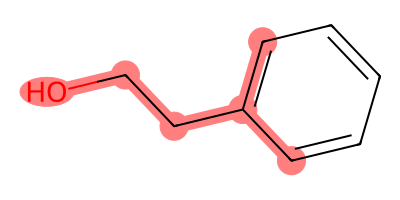

In [247]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('OCCc1ccccc1')
substructure = Chem.MolFromSmarts('[O&H1:45][C&H2:46][C&H2:47][c:48]([c&H1:49])[c&H1:53]')
SVG(increase_resolution(mol, substructure))

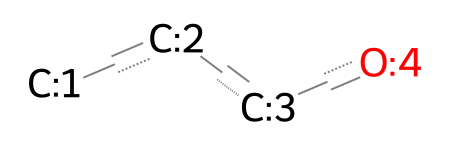

In [124]:
Chem.MolFromSmarts('')

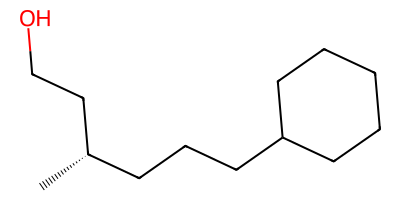

In [232]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('OCC[C@H](CCCC1CCCCC1)C')
substructure = Chem.MolFromSmarts('[C&H2:2]([C@@&H1:1]([C&H2:5])[C&H3])[C&H2:3][O&H1:4]')
SVG(increase_resolution(mol, substructure))

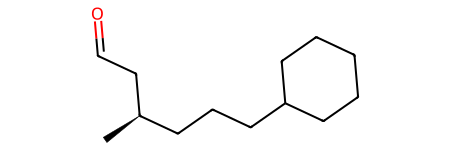

In [235]:
mol = Chem.MolFromSmiles('O=CC[C@@H](CCCC1CCCCC1)C')
mol

# Examine the molecules in each group

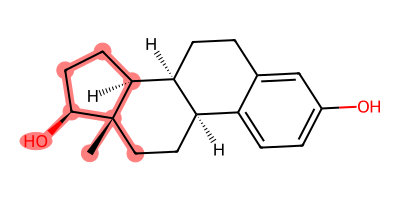

In [59]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@@H]3[C@@H]1CC[C@@H]2O')
substructure = Chem.MolFromSmarts('[C&H3:1][C@:2]1([C&H2:3])[C@&H1:4][C&H2:5][C&H2:6][C@@&H1:7]1[O&H1:8]')
SVG(increase_resolution(mol, substructure))

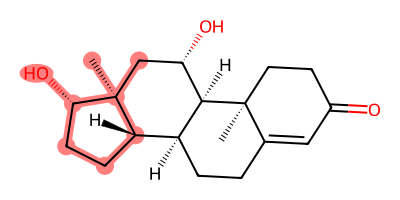

In [60]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('C[C@]12C[C@H](O)[C@@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2O')
substructure = Chem.MolFromSmarts('[C&H3:1][C@:2]1([C&H2:3])[C@&H1:4][C&H2:5][C&H2:6][C@@&H1:7]1[O&H1:8]')
SVG(increase_resolution(mol, substructure))

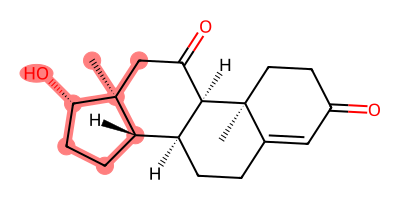

In [61]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('C[C@]12CC(=O)[C@@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C@@H]1CC[C@@H]2O')
substructure = Chem.MolFromSmarts('[C&H3:1][C@:2]1([C&H2:3])[C@&H1:4][C&H2:5][C&H2:6][C@@&H1:7]1[O&H1:8]')
SVG(increase_resolution(mol, substructure))

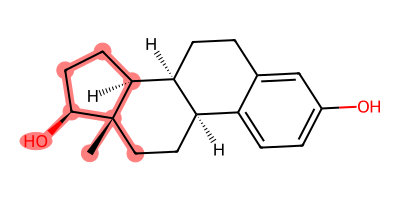

In [67]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@@H]3[C@@H]1CC[C@@H]2O')
substructure = Chem.MolFromSmarts('[C&H3:1][C@:2]1([C&H2:3])[C@&H1:4][C&H2:5][C&H2:6][C@@&H1:7]1[O&H1:8]')
SVG(increase_resolution(mol, substructure))

In [65]:
# Define the smaller (query) and larger (target) molecules
smaller_molecule = Chem.MolFromSmarts('[C&H3:1][C@:2]1([C&H2:3])[C@&H1:4][C&H2:5][C&H2:6][C@@&H1:7]1[O&H1:8]')  # e.g., ethanol
larger_molecule = Chem.MolFromSmiles('C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@@H]3[C@@H]1CC[C@@H]2O')  # e.g., butanol

# Check if the smaller molecule is a substructure of the larger molecule
is_subset = larger_molecule.HasSubstructMatch(smaller_molecule, useChirality = True)

# Output the result
print(f"Is the smaller molecule a subset of the larger one? {is_subset}")

Is the smaller molecule a subset of the larger one? False


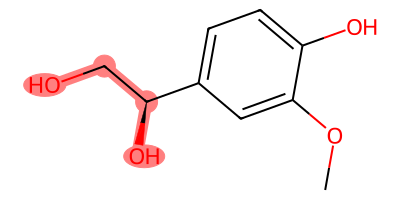

In [2]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('COc1cc([C@@H](O)CO)ccc1O')
substructure = Chem.MolFromSmarts('[C@@H:6]([OH:7])[CH2:8][OH:9]')
SVG(increase_resolution(mol, substructure))

In [3]:
smaller_smiles = Chem.MolToSmiles(smaller_molecule, isomericSmiles=True)
larger_smiles = Chem.MolToSmiles(larger_molecule, isomericSmiles=True)

print("Smaller molecule SMILES:", smaller_smiles)
print("Larger molecule SMILES:", larger_smiles)


NameError: name 'smaller_molecule' is not defined

In [ ]:
Chem.MolFromSmarts('[CH3:1][O:2][c:3]1[cH:4][c:5]([C@@H:6]([OH:7])[CH2:8][OH:9])[cH:10][cH:11][c:12]1[OH:13]')

In [ ]:
Chem.MolFromSmarts('[C@@H:1]([OH:2])[CH2:3][OH:4]')

In [4]:
from rdkit import Chem

# Define the smaller (query) molecule with additional context
smaller_molecule = Chem.MolFromSmarts('[C:5][C@@H:6]([OH:7])[CH2:8][OH:9]')
Chem.SanitizeMol(smaller_molecule)
smaller_molecule = Chem.AddHs(smaller_molecule)
Chem.AssignStereochemistry(smaller_molecule, force=True)

# Define the larger (target) molecule
larger_molecule = Chem.MolFromSmiles('COc1cc([C@H](O)CO)ccc1O')
Chem.SanitizeMol(larger_molecule)
larger_molecule = Chem.AddHs(larger_molecule)
Chem.AssignStereochemistry(larger_molecule, force=True)

# Verify chiral centers
print("Chiral centers in query:", Chem.FindMolChiralCenters(smaller_molecule, includeUnassigned=True))
print("Chiral centers in target:", Chem.FindMolChiralCenters(larger_molecule, includeUnassigned=True))

# Perform substructure matching
is_subset = larger_molecule.HasSubstructMatch(smaller_molecule, useChirality=True)
print(f"Is the smaller molecule a subset of the larger one? {is_subset}")

# Get and print matches
matches = larger_molecule.GetSubstructMatches(smaller_molecule, useChirality=True)
print("Matches:", matches)

Chiral centers in query: [(1, 'R')]
Chiral centers in target: [(5, 'S')]
Is the smaller molecule a subset of the larger one? False
Matches: ()


In [5]:
# Define the smaller (query) and larger (target) molecules
#smaller_molecule = Chem.MolFromSmarts('[CH3:1][O:2][c:3]1[cH:4][c:5]([C@@H:6]([OH:7])[CH2:8][OH:9])[cH:10][cH:11][c:12]1[OH:13]')  # e.g., ethanol
smaller_molecule = Chem.MolFromSmarts('[C@@H:6]([OH:7])[CH2:8][OH:9]')
Chem.SanitizeMol(smaller_molecule, Chem.SanitizeFlags.SANITIZE_ALL)
smaller_molecule = Chem.AddHs(smaller_molecule)

larger_molecule = Chem.MolFromSmiles('COc1cc([C@H](O)CO)ccc1O')  # e.g., butanol
Chem.SanitizeMol(larger_molecule, Chem.SanitizeFlags.SANITIZE_ALL)
larger_molecule = Chem.AddHs(larger_molecule)

Chem.AssignStereochemistry(smaller_molecule, cleanIt=True, force=True)
Chem.AssignStereochemistry(larger_molecule, cleanIt=True, force=True)

# Check if the smaller molecule is a substructure of the larger molecule
is_subset = larger_molecule.HasSubstructMatch(smaller_molecule, useChirality = True)

# Output the result
print(f"Is the smaller molecule a subset of the larger one? {is_subset}")

for match in larger_molecule.GetSubstructMatches(smaller_molecule):
    print(match)

Is the smaller molecule a subset of the larger one? True
(5, 6, 7, 8, 17, 18, 19, 20, 21)


In [6]:
# Define the smaller (query) and larger (target) molecules
smaller_molecule = Chem.MolFromSmarts('[O:1][C@@&H1:2]([O&H1:3])[C@@&H1:4][O&H1:5]')  # e.g., ethanol
Chem.SanitizeMol(smaller_molecule, Chem.SanitizeFlags.SANITIZE_ALL)
smaller_molecule = Chem.AddHs(smaller_molecule)

larger_molecule = Chem.MolFromSmiles('O[C@H]1[C@@H](CO)O[C@H](O)[C@H](O)[C@H]1O')  # e.g., butanol
Chem.SanitizeMol(larger_molecule, Chem.SanitizeFlags.SANITIZE_ALL)
larger_molecule = Chem.AddHs(larger_molecule)

Chem.AssignStereochemistry(smaller_molecule, cleanIt=True, force=True)
Chem.AssignStereochemistry(larger_molecule, cleanIt=True, force=True)

# Check if the smaller molecule is a substructure of the larger molecule
is_subset = larger_molecule.HasSubstructMatch(smaller_molecule, useChirality = True)

# Output the result
print(f"Is the smaller molecule a subset of the larger one? {is_subset}")

for match in larger_molecule.GetSubstructMatches(smaller_molecule):
    print(match)

Is the smaller molecule a subset of the larger one? True
(5, 6, 7, 8, 9)


In [7]:
matches = larger_molecule.GetSubstructMatches(smaller_molecule, useChirality=True)
print(f"Matches: {matches}")


Matches: ((5, 6, 7, 8, 9),)


In [8]:
molecule = Chem.MolFromSmiles('[C@H](Cl)(Br)I')
shouldMatch = Chem.MolFromSmarts('[C@H](Cl)(Br)I')
shouldNotMatch = Chem.MolFromSmarts('[C@@H](Cl)(Br)I')
molecule.HasSubstructMatch(shouldMatch, useChirality=True)

True

In [9]:

molecule.HasSubstructMatch(shouldNotMatch, useChirality=True)
#True

False

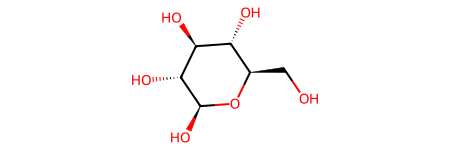

In [11]:
Chem.MolFromSmiles('O[C@H]1[C@H](O)[C@@H](O)[C@H](O)[C@@H](CO)O1')

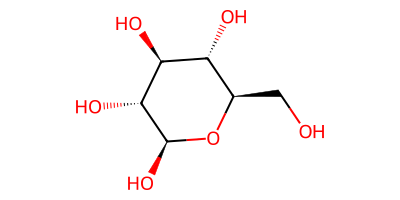

In [52]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure, useChirality = True), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('O[C@H]1[C@H](O)[C@@H](O)[C@H](O)[C@@H](CO)O1')
substructure = Chem.MolFromSmarts('[C&H1:1][C@H:2]([O:3])[O&H1:4]')
SVG(increase_resolution(mol, substructure))


Reaction SMARTS: [C&H1:1][C@H:2]([O:3])[O&H1:4]>>[C&H1:1][C@@H:2]([O:3])[O&H1:4]


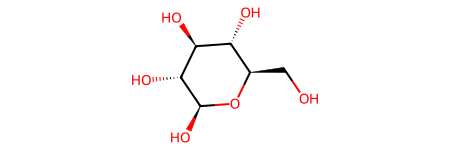


Input SMILES: O[C@H]1[C@H](O)[C@@H](O)[C@H](O)[C@@H](CO)O1


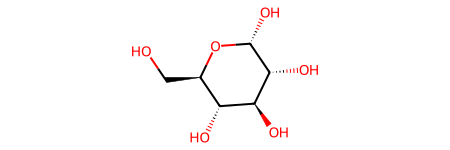


1 RDKit outcomes: OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O


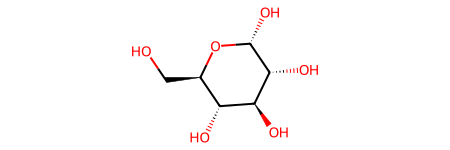

1 RDChiral outcomes: OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@@H]1O


In [51]:
reaction_smarts = '[C&H1:1][C@H:2]([O:3])[O&H1:4]>>[C&H1:1][C@@H:2]([O:3])[O&H1:4]'
show_outcomes(reaction_smarts, reactant_smiles = 'O[C@H]1[C@H](O)[C@@H](O)[C@H](O)[C@@H](CO)O1')


In [33]:
# With the substructures extracted above, we generate chiral reaction fingerprints and group reactions together
useChirality = False

# initialize an empty numpy array on which we will vertically stack morgan fingerprints
all_fps = np.empty((0, nBits))

# Generate the Morgan fingerprint for the substructure only
for env_smarts in list(AdH_rxns_df_w_substructs['substructure_environments']):
    env_mol = Chem.MolFromSmarts(env_smarts)
    Chem.SanitizeMol(env_mol, Chem.SanitizeFlags.SANITIZE_ALL)
    chiral_fingerprint_env = np.array(AllChem.GetMorganFingerprintAsBitVect(env_mol, 
                                                                            radius = radius, 
                                                                            nBits = nBits, 
                                                                            useChirality = False))

    all_fps = np.vstack((all_fps, chiral_fingerprint_env))

In [34]:
### Perform groupings here

# Step 1: Identify unique rows and group identical rows together
unique_rows, indices, inverse_indices = np.unique(all_fps, axis=0, return_index=True, return_inverse=True)

# Step 2: Count the number of unique groups
num_groups = unique_rows.shape[0]

# Step 3: Grouping rows by identical entries using inverse_indices
groups = {i: np.where(inverse_indices == i)[0].tolist() for i in range(num_groups)}

# Output the result
print(f"\nNumber of unique groups: {num_groups}")
print(f"\nGroups of identical rows: {groups}")


Number of unique groups: 74

Groups of identical rows: {0: [311, 355], 1: [177, 184], 2: [7], 3: [45, 48], 4: [138], 5: [357], 6: [46, 47, 50, 51], 7: [139], 8: [161], 9: [75, 103, 135], 10: [95], 11: [322], 12: [9, 119, 211, 227, 230], 13: [116], 14: [216], 15: [1, 3, 4, 80, 81, 92, 113, 114, 120, 124, 169, 342, 348, 354], 16: [93], 17: [376], 18: [69, 70, 91], 19: [5, 106, 107, 108, 115, 134, 243, 269], 20: [219, 307, 308], 21: [289], 22: [238, 287], 23: [194, 319, 320, 367, 368], 24: [30, 31, 52, 105, 242, 276, 280, 281, 283, 284, 285, 326, 331], 25: [71, 72, 112, 142, 150, 151, 152, 153, 154, 155, 333, 345, 346], 26: [15, 16, 18, 19, 99, 104, 125, 126, 273, 274, 278, 279, 295, 330], 27: [323, 324], 28: [83, 84], 29: [237], 30: [171], 31: [85, 343], 32: [168, 347, 360, 361, 362, 363, 364, 365, 366, 370, 372], 33: [2, 217], 34: [0, 28, 29, 102, 117, 118, 121, 128, 129, 165, 286, 344, 353, 356], 35: [6, 12, 17, 20, 21, 23, 24, 25, 32, 33, 34, 35, 36, 76, 77, 78, 79, 88, 90, 162, 163,

In [35]:
dummy_group_numbers = np.zeros(all_fps.shape[0])
for group_num in list(groups.keys()):
    row_indexes = groups[group_num]
    dummy_group_numbers[row_indexes] = int(group_num)

In [36]:
AdH_rxns_df_w_substructs['subrule_group'] = dummy_group_numbers

/var/folders/g7/7p1djmms7lxdrm3nk5jjxs680000gn/T/ipykernel_63439/3616583253.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AdH_rxns_df_w_substructs['subrule_group'] = dummy_group_numbers


In [37]:
AdH_rxns_df_w_substructs

,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx,substructure_environments,Group,subrule_group
4,2324,[CH3:1][O:2][c:3]1[cH:4][c:5]([C@@H:6]([OH:7])...,COc1cc([C@@H](O)CO)ccc1O.NC(=O)c1ccc[n+]([C@@H...,RXN-10915,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,8,[c:5][C@@&H1:6]([O&H1:7])[C&H2:8][O&H1:9],1.0,34.0
7,5135,[CH3:1][C@@H:2]([OH:3])[CH2:4][CH2:5][OH:6].[N...,C[C@@H](O)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](CO...,RXN-21862,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,5,[C&H2:4]([C@@&H1:2])[C&H2:5][O&H1:6],2.0,15.0
9,5743,[CH3:1][CH:2]([CH3:3])[CH2:4][OH:5].[NH2:6][C:...,CC(C)CO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(...,RXN-7657,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,4,[C&H3:1][C&H1:2]([C&H3:3])[C&H2:4][O&H1:5],3.0,33.0
11,5751,[CH3:1][CH:2]([CH3:3])[CH2:4][CH2:5][OH:6].[NH...,CC(C)CCO.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)...,RXN-7693,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,5,[C&H1:2][C&H2:4][C&H2:5][O&H1:6],4.0,15.0
14,5753,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,RXN-7700,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.1,rule0002,46,[O&H1:45][C&H2:46][C&H2:47][c:48],5.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,95,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,1.1.1.97-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.97,rule0002,50,[O&H1:49][C&H2:50][c:51]([c&H1:52])[c&H1:57],213.0,32.0
836,96,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCCCCCCCCCC[C@@H](O)C(=O)[O-].NC(=O)c1ccc...,1.1.1.98-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.98,rule0002,17,[C&H2:15][C&H2:16][C@@&H1:17]([O&H1:18])[C:19]...,185.0,70.0
837,97,[CH3:1][CH2:2][CH2:3][CH2:4][CH2:5][CH2:6][CH2...,CCCCCCCCCCCCCCCC[C@H](O)C(=O)[O-].NC(=O)c1ccc[...,1.1.1.99-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.99,rule0002,17,[C&H2:15][C&H2:16][C@&H1:17]([O&H1:18])[C:19](...,186.0,70.0
881,105,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,1.10.1.1-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single from multi,1.0,NaN,NaN,[],NaN,1.10.1.1,rule0002,50,[O&H1:49][C@&H1:50]1[c:51]([c&H1:52])[c:60][c:...,218.0,47.0


In [38]:
list(AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['subrule_group']==3]['substructure_environments'])

['[C&H1:14]=[C&H1:15]/[C@@&H1:16]([O&H1:17])[C@@&H1:18]([O&H1:19])[C&H2:20]',
 '[C&H2:5][C@&H1:6]([O&H1:7])[C@&H1:8]([O&H1:9])/[C&H1:10]=[C&H1:11]']

In [39]:
for r in list(AdH_rxns_df_w_substructs[AdH_rxns_df_w_substructs['subrule_group']==3]['unmapped']):
    print(r)
    print()

CC/C=C\C[C@H](O)/C=C/C=C\C=C\C=C\[C@@H](O)[C@@H](O)C/C=C\CCC(=O)[O-].NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CC/C=C\C[C@H](O)/C=C/C=C\C=C\C=C\C(=O)[C@@H](O)C/C=C\CCC(=O)[O-].NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]

CC/C=C\C[C@H](O)[C@H](O)/C=C/C=C/C=C\C=C\[C@@H](O)C/C=C\CCC(=O)[O-].NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>CC/C=C\C[C@H](O)C(=O)/C=C/C=C/C=C\C=C\[C@@H](O)C/C=C\CCC(=O)[O-].NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1.[H+]



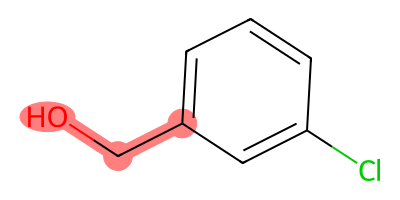

In [40]:
def increase_resolution(mol, substructure, size=(400, 200)):
    
    mol = deepcopy(mol)
    substructure = deepcopy(substructure)
    drawer = rdMolDraw2D.MolDraw2DSVG(size[0], size[1])
    
    # highlightAtoms expects only one tuple, not tuple of tuples. So it needs to be merged into a single tuple
    matches = sum(mol.GetSubstructMatches(substructure), ())
    drawer.DrawMolecule(mol, highlightAtoms=matches)
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    
    return svg.replace('svg:','')


mol = Chem.MolFromSmiles('OCc1cccc(Cl)c1')
substructure = Chem.MolFromSmarts('[O&H1:122][C&H2:12][c:13]')
SVG(increase_resolution(mol, substructure))

In [41]:
group_num = 1
row_indices = groups[group_num]
for r in list(AdH_rxns_df.iloc[row_indices,:]['unmapped']):
    print(r.split('>>')[0].split('.'))

['NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1', 'O=C([O-])[C@H](O)[C@@H](O)[C@H](O)[C@@H](O)CO']
['CC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@@H]4C[C@@H](O)CC[C@]4(C)[C@H]3CC[C@]12C', 'NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](OP(=O)(O)O)[C@@H]3O)[C@@H](O)[C@H]2O)c1']


In [42]:
AdH_rxns_df.iloc[row_indices,:]

,rxn_idx,mapped,unmapped,orig_rxn_text,rule,rule_id,source,steps,quality,natural,organism,protein_refs,protein_db,ec_num,JN_labelled_rule,Reaction_site_idx
357,63,[NH2:1][C:2](=[O:3])[c:4]1[cH:5][cH:6][cH:7][n...,NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)...,1.1.1.264-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.264,rule0002,58
391,73,[CH3:1][C:2](=[O:3])[C@H:4]1[CH2:5][CH2:6][C@H...,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC[C@@H]4C[C@@H](O)...,1.1.1.277-RXN,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,1,direct,single,1.0,NaN,NaN,[],NaN,1.1.1.277,rule0002,13


In [43]:
from rdkit import Chem

# List of atom-mapped SMARTS strings
smarts_list = [
    '[C&H2:50][C@@&H1:51]([O&H1:52])[C@&H1:53]',
    '[C&H3:1][C@@&H1:2]([O&H1:3])[C@&H1:4]',
    '[C&H2:49][C@&H1:50]([O&H1:51])[C&H2:52]'
]

# Function to standardize atom mapping numbers sequentially
def standardize_atom_mapping(smarts):
    mol = Chem.MolFromSmarts(smarts)
    
    # Assign new atom mapping numbers in the order of the atom indices
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetAtomMapNum(i + 1)  # Sequential mapping starting from 1
    
    # Convert back to SMARTS
    return Chem.MolToSmarts(mol)

# Apply standardization to all SMARTS
standardized_smarts_list = [standardize_atom_mapping(smarts) for smarts in smarts_list]

# Output the standardized SMARTS strings
for i, standardized_smarts in enumerate(standardized_smarts_list):
    print(f"Standardized SMARTS {i + 1}: {standardized_smarts}")


Standardized SMARTS 1: [C&H2:1][C@@&H1:2]([O&H1:3])[C@&H1:4]
Standardized SMARTS 2: [C&H3:1][C@@&H1:2]([O&H1:3])[C@&H1:4]
Standardized SMARTS 3: [C&H2:1][C@&H1:2]([O&H1:3])[C&H2:4]


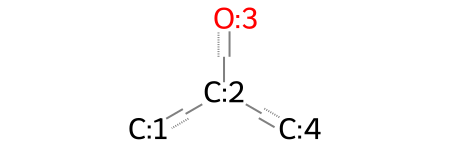

In [44]:
Chem.MolFromSmarts('[C&H2:1][C@&H1:2]([O&H1:3])[C&H2:4]')

In [45]:
from rdkit import Chem
from rdkit.Chem import Draw

# List of atom-mapped SMARTS strings
smarts_list = [
    '[C&H2:50][C@@&H1:51]([O&H1:52])[C@&H1:53]',
    '[C&H3:1][C@@&H1:2]([O&H1:3])[C@&H1:4]',
    '[C&H2:49][C@&H1:50]([O&H1:51])[C&H2:52]'
]

# Convert the SMARTS strings to RDKit molecules
molecules = [Chem.MolFromSmarts(smarts) for smarts in smarts_list]

# Draw the molecules with stereochemistry and atom mapping visible
img = Draw.MolsToGridImage(molecules, molsPerRow=3, subImgSize=(300, 300), useSVG=False)


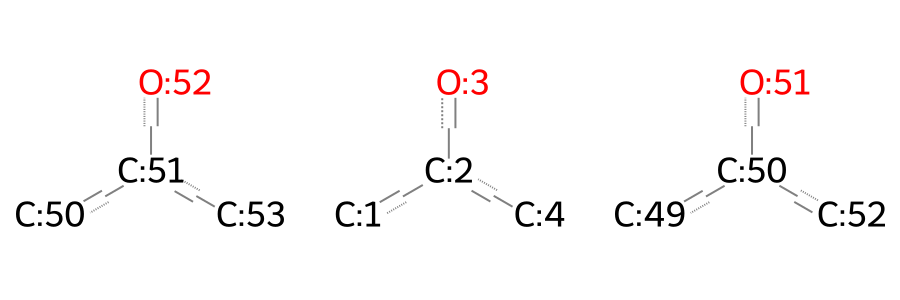

In [46]:
img

In [47]:
from rdkit.Chem import Draw

# Function to prepare molecules for drawing and show atom mappings
def prepare_molecule_for_drawing(mol):
    # Explicitly show atom mapping numbers
    for atom in mol.GetAtoms():
        if atom.GetAtomMapNum() > 0:
            atom.SetProp("atomLabel", f"{atom.GetSymbol()}:{atom.GetAtomMapNum()}")
    return mol

# Prepare molecules for drawing with atom mapping numbers visible
prepared_molecules = [prepare_molecule_for_drawing(mol) for mol in molecules]

# Draw the molecules in a grid
img = Draw.MolsToGridImage(prepared_molecules, molsPerRow=3, subImgSize=(300, 300), useSVG=False)


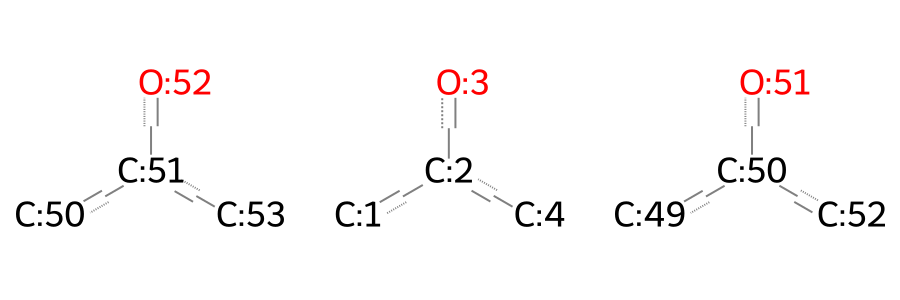

In [48]:
img

In [49]:
get_env_around_reaction_site_single_reactant('[CH3:1][CH2:2][OH:3]', 1, 2)

'[C&H2:2][O&H1:3]'

In [50]:
Chem.MolFromSmarts(smarts1)

NameError: name 'smarts1' is not defined

In [ ]:
mol1 = Chem.MolFromSmarts(smarts1)
Chem.SanitizeMol(mol1, Chem.SanitizeFlags.SANITIZE_ALL)
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol1, radius=2, nBits=2048)
fingerprint_bits1 = np.array(fingerprint)

In [ ]:
atom_mapped_substrate_smarts2 = '[OH:49][CH2:50][C@@H:51]([OH:52])[C@H:53]([OH:54])[C@@H:55]([OH:56])[CH2:57][OH:58]'#'[CH3:1][C@@H:2]([OH:3])[CH2:4][CH2:5][OH:6]'
radius = 1
starting_atom_idx = 51
smarts2 = get_env_around_reaction_site_single_reactant(atom_mapped_substrate_smarts2, radius, starting_atom_idx)
print(smarts2)

In [ ]:
Chem.MolFromSmarts(smarts2)

In [ ]:
mol2 = Chem.MolFromSmarts(smarts2)
Chem.SanitizeMol(mol2, Chem.SanitizeFlags.SANITIZE_ALL)
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol2, radius=2, nBits=2048)
fingerprint_bits2 = np.array(fingerprint)

In [ ]:
np.array_equal(fingerprint_bits1,fingerprint_bits2)

In [ ]:
substrate_mol = Chem.MolFromSmarts('[CH3:1][O:2][c:3]1[cH:4][c:5]([C@@H:6]([OH:7])[CH:8]=[O:9])[cH:10][cH:11][c:12]1[OH:13]')
env = Chem.FindAtomEnvironmentOfRadiusN(mol = substrate_mol, radius = 6, rootedAtAtom = 8)

In [ ]:
bond_indices = list(env)
atom_indices = set()
for bond_idx in bond_indices:
    bond = substrate_mol.GetBondWithIdx(bond_idx)
    atom_indices.add(bond.GetBeginAtomIdx())
    atom_indices.add(bond.GetEndAtomIdx())


In [ ]:
# Generate the SMARTS string for the substructure, using the atom indices
smarts = Chem.MolFragmentToSmarts(substrate_mol, atomsToUse=list(atom_indices))

# Output the corrected SMARTS
print(f"Corrected SMARTS: {smarts}")

In [ ]:
Chem.MolFromSmarts(smarts)

In [ ]:
list(env)

In [ ]:
# Convert the RDKit vector of integers to a Python list
atom_indices = list(env)
    
# Generate the SMARTS string for the substructure
smarts = Chem.MolFragmentToSmarts(substrate_mol, atomsToUse=atom_indices)
    

In [ ]:
smarts

In [ ]:
Chem.MolFromSmarts(smarts)

In [2]:
reaction_smarts = '[c&H1:4][c:5][C@@&H1:6]([O&H1:7])[C&H2:8][O&H1:9]>>[c&H1:4][c:5][C@@&H1:6]([O&H1:7])[C&H1:8]=[O:9]'
reaction_smiles = 'COc1cc([C@@H](O)CO)ccc1O.NC(=O)c1ccc[n+]([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)c1>>COc1cc([C@@H](O)C=O)ccc1O.NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OC[C@H]3O[C@@H](n4cnc5c(N)ncnc54)[C@H](O)[C@@H]3O)[C@@H](O)[C@H]2O)C=CC1'

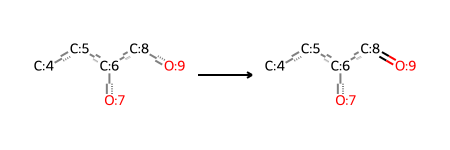

In [3]:
rdChemReactions.ReactionFromSmarts(reaction_smarts)

In [35]:
def show_outcomes(reaction_smarts, reactant_smiles):
    
    # normal version
    outcomes_rdkit_mol = AllChem.ReactionFromSmarts(reaction_smarts).RunReactants((Chem.MolFromSmiles(reactant_smiles),))
    outcomes_rdkit = set()
    for outcome in outcomes_rdkit_mol:
        outcomes_rdkit.add('.'.join(sorted([Chem.MolToSmiles(x) for x in outcome])))
    # rdchiral version
    outcomes_rdchiral = rdchiralRunText(reaction_smarts, reactant_smiles)
    
    print('\nReaction SMARTS: {}'.format(reaction_smarts))
    display(Chem.MolFromSmiles(reactant_smiles))
    print('\nInput SMILES: {}'.format(reactant_smiles))
    
    if outcomes_rdkit:
        display(Chem.MolFromSmiles('.'.join(outcomes_rdkit)))
    print('\n{:1d} RDKit outcomes: {}'.format(len(outcomes_rdkit),'.'.join(outcomes_rdkit)))
    
    if outcomes_rdkit:
        display(Chem.MolFromSmiles('.'.join(outcomes_rdchiral)))
    print('{:1d} RDChiral outcomes: {}'.format(len(outcomes_rdchiral),'.'.join(outcomes_rdchiral)))


Reaction SMARTS: [c&H1:4][c:5][C@@&H1:6]([O&H1:7])[C&H2:8][O&H1:9]>>[c&H1:4][c:5][C@@&H1:6]([O&H1:7])[C&H1:8]=[O:9]


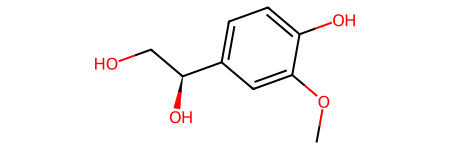


Input SMILES: COc1cc([C@@H](O)CO)ccc1O


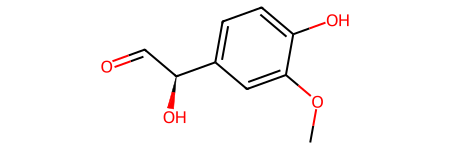


1 RDKit outcomes: COc1cc([C@@H](O)C=O)ccc1O


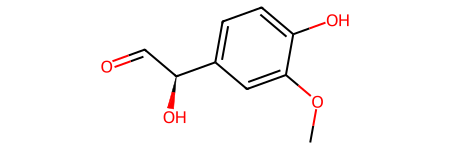

1 RDChiral outcomes: COc1cc([C@@H](O)C=O)ccc1O


In [5]:
show_outcomes(reaction_smarts, reactant_smiles = 'COc1cc([C@@H](O)CO)ccc1O')

In [6]:
substructure_mol = Chem.MolFromSmarts('[c&H1:4][c:5][C@@&H1:6]([O&H1:7])[C&H2:8][O&H1:9]')
substrate_mol = Chem.MolFromSmiles('COc1cc([C@@H](O)CO)ccc1O')
match = rdFMCS.FindMCS([substructure_mol, substrate_mol], matchChiralTag = True)

In [7]:
print(match.smartsString)

[#6]:[#6]-[#6](-[#8])-[#6]-[#8]


In [8]:
from rdkit import Chem

# Define the smaller (query) and larger (target) molecules
smaller_molecule = Chem.MolFromSmarts('[c&H1:4][c:5][C@&H1:6]([O&H1:7])[C&H2:8][O&H1:9]')  # e.g., ethanol
larger_molecule = Chem.MolFromSmiles('COc1cc([C@@H](O)CO)ccc1O')  # e.g., butanol

# Check if the smaller molecule is a substructure of the larger molecule
is_subset = larger_molecule.HasSubstructMatch(smaller_molecule, useChirality = True)

# Output the result
print(f"Is the smaller molecule a subset of the larger one? {is_subset}")


Is the smaller molecule a subset of the larger one? False


In [50]:
from rdkit import Chem

# Define the smaller (query) and larger (target) molecules
smaller_molecule = Chem.MolFromSmarts('[c&H1:1][c:2][C@@&H1:3]([O&H1:4])[C&H2:5][O&H1:6]')  # e.g., ethanol
larger_molecule = Chem.MolFromSmiles('COc1cc([C@@H](O)CO)ccc1O')  # e.g., butanol

# Check if the smaller molecule is a substructure of the larger molecule
is_subset = larger_molecule.HasSubstructMatch(smaller_molecule, useChirality = True)

# Output the result
print(f"Is the smaller molecule a subset of the larger one? {is_subset}")


Is the smaller molecule a subset of the larger one? True


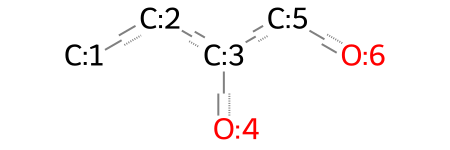

In [47]:
Chem.MolFromSmarts('[c&H1:1][c:2][C@@&H1:3]([O&H1:4])[C&H2:5][O&H1:6]')

In [10]:
def are_smarts_equivalent(smarts1, smarts2, use_chirality=False):
    # Convert SMARTS strings to RDKit molecule objects
    mol1 = Chem.MolFromSmarts(smarts1)
    mol2 = Chem.MolFromSmarts(smarts2)
    
    # Check if mol1 is a substructure of mol2 and mol2 is a substructure of mol1
    match1 = mol2.HasSubstructMatch(mol1, useChirality=use_chirality)
    match2 = mol1.HasSubstructMatch(mol2, useChirality=use_chirality)
    
    # If both are true, the two SMARTS patterns describe the same substructure
    return match1 and match2

In [11]:
are_smarts_equivalent('[c&H1:1][c:2][C@@&H1:3]([O&H1:4])[C&H2:5][O&H1:6]',
                      '[c&H1:4][c:5][C@@&H1:6]([O&H1:7])[C&H2:8][O&H1:9]')

RuntimeError: Pre-condition Violation
	getNumImplicitHs() called without preceding call to calcImplicitValence()
	Violation occurred on line 289 in file Code/GraphMol/Atom.cpp
	Failed Expression: d_implicitValence > -1
	RDKIT: 2024.03.5
	BOOST: 1_85


In [12]:
from rdkit import Chem

def are_smarts_equivalent(smarts1, smarts2, use_chirality=False):
    try:
        # Convert SMARTS strings to RDKit molecule objects
        mol1 = Chem.MolFromSmarts(smarts1)
        mol2 = Chem.MolFromSmarts(smarts2)

        # Sanitize the molecules to compute implicit valence and hydrogens
        Chem.SanitizeMol(mol1, Chem.SanitizeFlags.SANITIZE_ALL)
        Chem.SanitizeMol(mol2, Chem.SanitizeFlags.SANITIZE_ALL)
        
        # Check if mol1 is a substructure of mol2 and mol2 is a substructure of mol1
        match1 = mol2.HasSubstructMatch(mol1, useChirality=use_chirality)
        match2 = mol1.HasSubstructMatch(mol2, useChirality=use_chirality)
        
        # If both are true, the two SMARTS patterns describe the same substructure
        return match1 and match2
    
    except Exception as e:
        print(f"Error during SMARTS comparison: {e}")
        return False

# Example SMARTS patterns
smarts_pattern_1 = '[c&H1:1][c:2][C@@&H1:3]([O&H1:4])[C&H2:5][O&H1:6]'
smarts_pattern_2 = '[c&H1:4][c:5][C@@&H1:6]([O&H1:7])[C&H2:8][O&H1:9]'

# Check if the two SMARTS patterns are equivalent (with or without chirality)
equivalent = are_smarts_equivalent(smarts_pattern_1, smarts_pattern_2, use_chirality=False)

print(f"Are the two SMARTS patterns equivalent? {equivalent}")

Are the two SMARTS patterns equivalent? False


In [13]:
# Define a SMARTS pattern and convert it to an RDKit molecule
smarts = "[c&H1:1][c:2][C@@&H1:3]([O&H1:4])[C&H2:5][O&H1:6]"
mol = Chem.MolFromSmarts(smarts)
Chem.SanitizeMol(mol, Chem.SanitizeFlags.SANITIZE_ALL)

# Generate Morgan fingerprints for the molecule (radius=2, bit vector size=2048)
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

# Convert the fingerprint to a list of bits
fingerprint_bits1 = np.array(fingerprint)

In [14]:
# Define a SMARTS pattern and convert it to an RDKit molecule
smarts = "[c&H1:4][c:5][C@@&H1:6]([O&H1:7])[C&H2:8][O&H1:9]"
mol = Chem.MolFromSmarts(smarts)
Chem.SanitizeMol(mol, Chem.SanitizeFlags.SANITIZE_ALL)

# Generate Morgan fingerprints for the molecule (radius=2, bit vector size=2048)
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)

# Convert the fingerprint to a list of bits
fingerprint_bits2 = np.array(fingerprint)

In [15]:
np.array_equal(fingerprint_bits1,fingerprint_bits2)

True

In [16]:
list(AdH_rxns_df['unmapped'])[12]

NameError: name 'AdH_rxns_df' is not defined

In [ ]:
list(AdH_rxns_df['mapped'])[12]